In [56]:
import jsonlines
import numpy as np
import pandas as pd
from scipy import stats
from itertools import product
from collections import defaultdict

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

np.random.seed(1)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['font.family'] = 'DeJavu Serif'

In [2]:
# meta data

name_sets = {1: ['Top', 'Male', '2000s', 'White'],
             2: ['Top', 'Female', '2000s', 'White'],
             3: ['Medium', 'Male', '2000s', 'White'],
             4: ['Medium', 'Female', '2000s', 'White'],
             5: ['Bottom', 'Male', '2000s', 'White'],
             6: ['Bottom', 'Female', '2000s', 'White'],
             7: ['Medium', 'Male', '2000s', 'Black'],
             8: ['Medium', 'Female', '2000s', 'Black'],
             9: ['Medium', 'Male', '2000s', 'Asian'],
             10: ['Medium', 'Female', '2000s', 'Asian'],
             11: ['Medium', 'Male', '2000s', 'Hispanic'],
             12: ['Medium', 'Female', '2000s', 'Hispanic'],
             13: ['Top', 'Male', '1970s', 'White'],
             14: ['Top', 'Female', '1970s', 'White'],
             15: ['Top', 'Male', '1940s', 'White'],
             16: ['Top', 'Female', '1940s', 'White']}

dimensions = {'Gender': {'Male':[1,3,5,7,9,11,13,15], 'Female':[2,4,6,8,10,12,14,16]},
              'Race': {'White':[3,4], 'Black':[7,8], 'Asian':[9,10], 'Hispanic':[11,12]},
              'Popularity': {'Top':[1,2], 'Medium':[3,4], 'Bottom':[5,6]},
              'Decade': {'2000s':[1,2], '1970s':[13,14], '1940s':[15,16]}}

In [3]:
# load the labels

labels = defaultdict(dict)
with jsonlines.open('../Data/General/Input/notes-label.jsonl', 'r') as reader:
    for line in reader:
        ID, position, name = map(lambda x:tuple(x), line.values())
        labels[ID][position] = name

In [4]:
# load the predictions

preds = {}
models = ['spaCy', 'Stanza', 'flair', 'Amazon', 'Microsoft', 'Google', 'NeuroNER', 'Philter', 'MIST']
for model in models:
    preds[model] = defaultdict(dict)
    
    with jsonlines.open(f'../Data/General/Output/notes-{model}.jsonl', 'r') as reader:
        for line in reader:
            ID, position, name = map(lambda x:tuple(x), line.values())
            preds[model][ID][position] = name

## Gender-Consistent Notes

- Group vs Model: Micro Recall, Bootstrapped Confidence Interval
- Gender-Consistent Notes vs All Notes: Wilcoxon Signed-Rank Test

In [5]:
# get the gender of the patient of each template

letter2word = {'M':'Male', 'F':'Female'}
noteID2gender = {}
for (noteID, _, _), mentions in labels.items():
    for _, (_, tag, _) in mentions.items():
        if tag[:8] == '**NAME-1': noteID2gender[noteID] = letter2word[tag[8]]

In [6]:
# only consider cases when the gender of the name set is consistent with the gender of the template

set2model2raw = defaultdict(lambda: defaultdict(list))
for ID, mentions in labels.items():
    if ID[1] not in dimensions['Gender'][noteID2gender[ID[0]]]: continue
    for position, (name, _, set_) in mentions.items():
        for model in models:
            if position in preds[model][ID] and name == preds[model][ID][position][0]: # true positive
                set2model2raw[set_][model].append(1)
            else: # false negative
                set2model2raw[set_][model].append(0)

In [7]:
# merge the raw data by group

dimension2group2model2raw = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for dimension, group2sets in dimensions.items():
    if dimension == 'Gender': continue
    for group, sets in group2sets.items():
        for model in models:
            for set_ in sets:
                dimension2group2model2raw[dimension][group][model] += set2model2raw[set_][model]
            dimension2group2model2raw[dimension][group][model] = np.array(dimension2group2model2raw[dimension][group][model])

In [8]:
# calculate the recall and confidence interval of each (group, model)

dimension2recall, dimension2yerr = {}, {}
for dimension, group2model2raw in dimension2group2model2raw.items():
    print()
    print(dimension)
    dimension2recall[dimension] = np.zeros((len(models), len(group2model2raw)))
    dimension2yerr[dimension] = np.zeros((len(models), 2, len(group2model2raw)))
    
    for groupID, (group, model2raw) in enumerate(group2model2raw.items()):
        print(group)
        
        for modelID, (model, raw) in enumerate(model2raw.items()):
            recall = np.mean(raw)
            ci = stats.bootstrap((raw,), np.mean).confidence_interval
            low, high = ci.low, ci.high
            print(f'Model: {model} | Recall: {recall:.3f} | Confidence Interval: ({low:.3f}, {high:.3f})')
            
            dimension2recall[dimension][modelID, groupID] = recall
            dimension2yerr[dimension][modelID, 0, groupID] = recall - low
            dimension2yerr[dimension][modelID, 1, groupID] = high - recall


Race
White
Model: spaCy | Recall: 0.623 | Confidence Interval: (0.612, 0.634)
Model: Stanza | Recall: 0.880 | Confidence Interval: (0.872, 0.887)
Model: flair | Recall: 0.964 | Confidence Interval: (0.959, 0.968)
Model: Amazon | Recall: 0.909 | Confidence Interval: (0.902, 0.915)
Model: Microsoft | Recall: 0.958 | Confidence Interval: (0.953, 0.962)
Model: Google | Recall: 0.854 | Confidence Interval: (0.846, 0.862)
Model: NeuroNER | Recall: 0.938 | Confidence Interval: (0.932, 0.943)
Model: Philter | Recall: 0.794 | Confidence Interval: (0.785, 0.804)
Model: MIST | Recall: 0.750 | Confidence Interval: (0.739, 0.759)
Black
Model: spaCy | Recall: 0.592 | Confidence Interval: (0.581, 0.603)
Model: Stanza | Recall: 0.871 | Confidence Interval: (0.863, 0.879)
Model: flair | Recall: 0.948 | Confidence Interval: (0.943, 0.953)
Model: Amazon | Recall: 0.879 | Confidence Interval: (0.871, 0.886)
Model: Microsoft | Recall: 0.922 | Confidence Interval: (0.916, 0.929)
Model: Google | Recall: 0.8

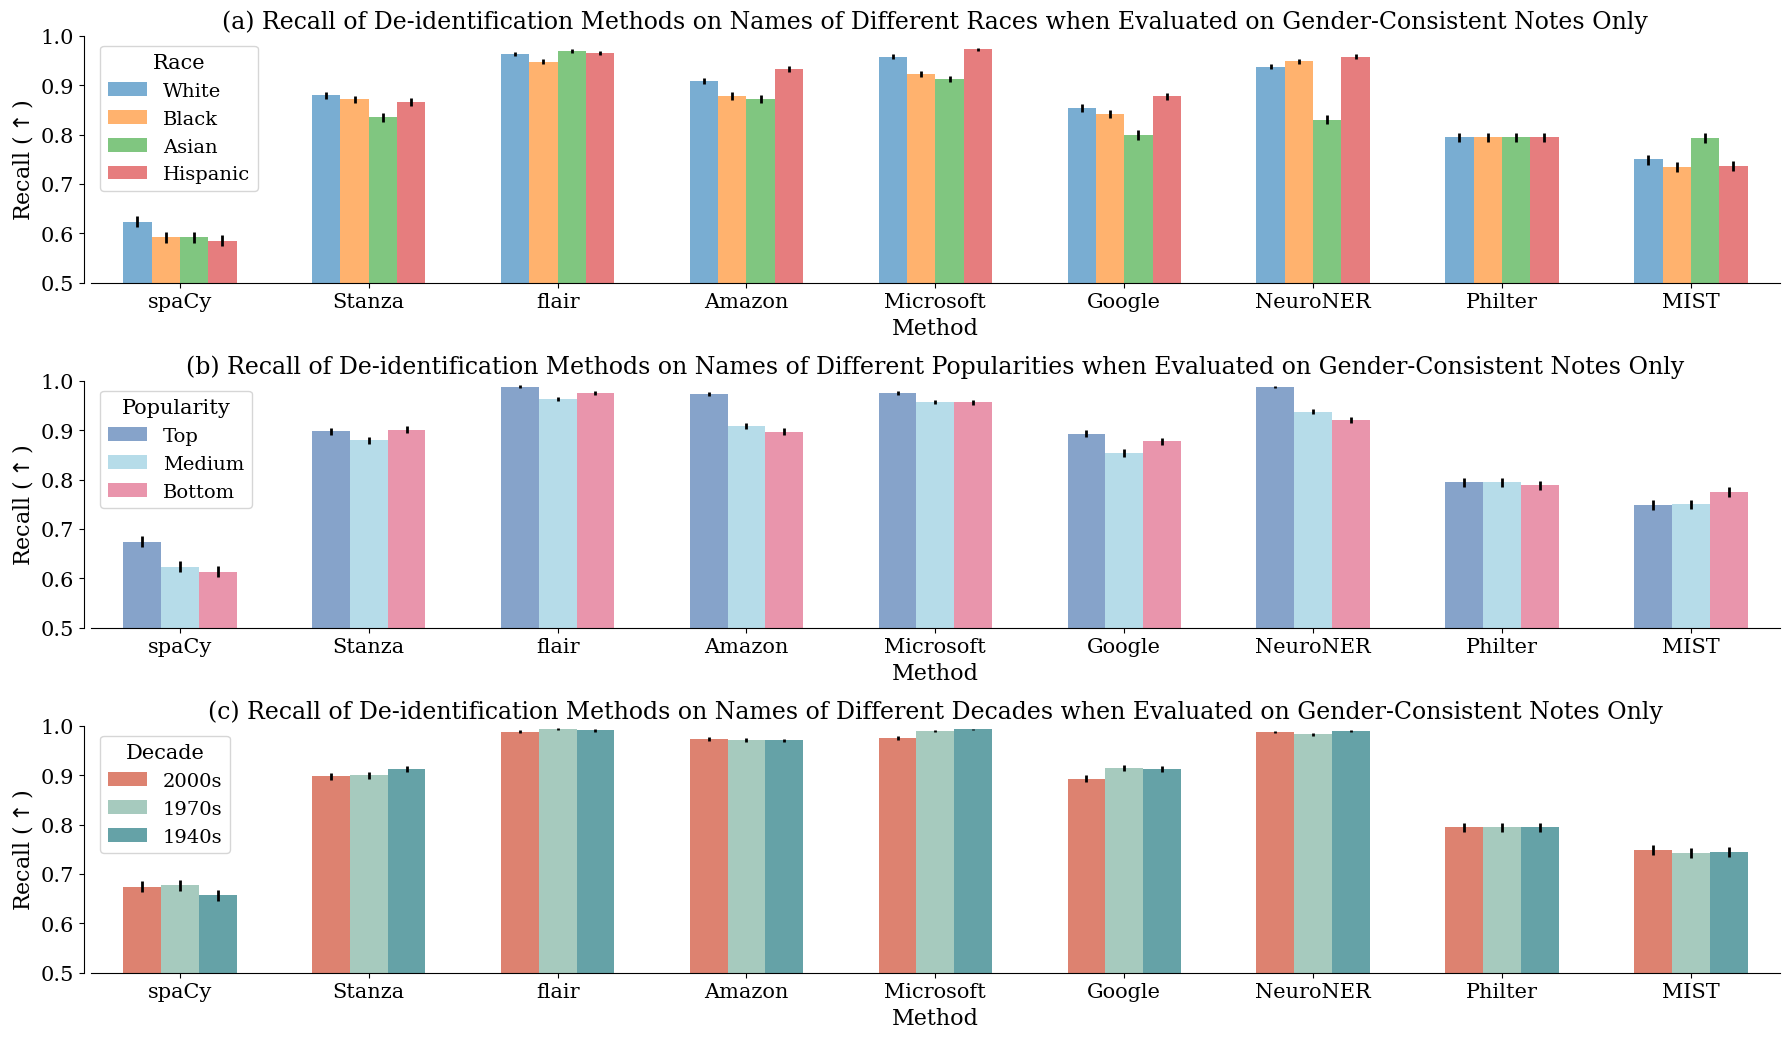

In [11]:
# plot the histogram of each (subgroup, model)

colorss = [['#79add2', '#ffb26e', '#80c680', '#e67d7e'], ['#86a3ca', '#b6dce9', '#e995ac'], ['#dd8270', '#a6cabe', '#65a2a7']]
colorss = [[mpl.colors.to_rgb(c) for c in cs] for cs in colorss]

def draw(did, dimension):
    
    ax = axs[did]
    colors = colorss[did]
    sns.despine(ax=ax, offset=dict(left=5))
    width, middle = 0.6/len(dimensions[dimension]), np.arange(len(models))
    for groupID, group in enumerate(dimensions[dimension]):
        ax.bar(middle+width*(groupID-len(dimensions[dimension])/2+0.5), dimension2recall[dimension][:,groupID], 
               label=group, width=width, color=colors[groupID], 
               yerr=dimension2yerr[dimension][:,:,groupID].T, error_kw=dict(ecolor='black', elinewidth=2))

    ax.margins(x=0.02)
    ax.set_ylim([0.5, 1])
    ax.set_xticks(range(len(models)))
    ax.set_xticklabels(models)
    ax.tick_params(axis='both', which='major', labelsize=fontsize-1)
    ax.set_xlabel('Method', fontsize=fontsize)
    ax.set_ylabel(r'Recall ($\uparrow$)', fontsize=fontsize)
    ax.legend(loc=2, title=dimension, title_fontsize=fontsize-1, fontsize=fontsize-2)
    ax.set_title('({}) Recall of De-identification Methods on Names of Different {} when Evaluated on Gender-Consistent Notes Only'
                 .format(chr(ord('a')+did), dimension+'s' if dimension[-1]!="y" else dimension[:-1]+'ies'), fontsize=fontsize+1)
    
fontsize = 16
if 'Gender' in dimensions: del dimensions['Gender']
fig, axs = plt.subplots(len(dimensions),1, figsize=(2*len(models), 3.5*len(dimensions)))
for did, dimension in enumerate(dimensions):
    draw(did, dimension)

plt.tight_layout()
plt.savefig('Figure/dimension_recall_no_gender.pdf')
plt.show()
plt.close(fig)

In [14]:
# calculate the recall of each (model, group) based on all the notes

set2model2raw = defaultdict(lambda: defaultdict(list))
for ID, mentions in labels.items():
    for position, (name, _, set_) in mentions.items():
        for model in models:
            if position in preds[model][ID] and name == preds[model][ID][position][0]: # true positive
                set2model2raw[set_][model].append(1)
            else: # false negative
                set2model2raw[set_][model].append(0)
                
dimension2group2model2raw = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for dimension, group2sets in dimensions.items():
    if dimension == 'Gender': continue
    for group, sets in group2sets.items():
        for model in models:
            for set_ in sets:
                dimension2group2model2raw[dimension][group][model] += set2model2raw[set_][model]
            dimension2group2model2raw[dimension][group][model] = np.array(dimension2group2model2raw[dimension][group][model])
            
all_dimension2recall = {}
for dimension, group2model2raw in dimension2group2model2raw.items():
    all_dimension2recall[dimension] = np.zeros((len(models), len(group2model2raw)))
    
    for groupID, (group, model2raw) in enumerate(group2model2raw.items()):        
        for modelID, (model, raw) in enumerate(model2raw.items()):
            recall = np.mean(raw)
            all_dimension2recall[dimension][modelID, groupID] = recall

In [26]:
# perform the Wilcoxon signed-rank Test to test whether the performance based on the gender-consistent notes only
# is from the same distribution as that based on the all notes

overall = np.concatenate([all_dimension2recall[dimension].flatten() for dimension in dimensions])
consistent = np.concatenate([dimension2recall[dimension].flatten() for dimension in dimensions])
res = stats.wilcoxon(overall, consistent)
print(f'Overall vs Gender-Consistent: P-value = {res.pvalue:.3f}, Significance = {True if res.pvalue<=0.05 else False}')

Overall vs Gender-Consistent: P-value = 0.082, Significance = False


## Difficult Note Templates

Consider only the hardest 20 templates
- Model: Overall Precision, Overall Recall, Overall F1, Bootstrap Standard Error
- Dimension vs Model: Mean of Absolute Difference in Recall and Bootstrap Standard Error, the Associated P-value by Friedman or Wilcoxon Tests

In [27]:
# identify the hardest 20 templates based on average recall

template2raw = defaultdict(list)
for ID, mentions in labels.items():
    for position, (name, _, _) in mentions.items():
        for model in models:
            if position in preds[model][ID] and name == preds[model][ID][position][0]:
                template2raw[ID[0]].append(1)
            else:
                template2raw[ID[0]].append(0)
                
recalls = []
for templateID in range(100):
    recalls.append(np.mean(template2raw[templateID]))
hardest = set(np.argsort(recalls)[:20])

In [28]:
# get the vectorized raw prediction results for the hardest 20 templates

def aggregate(model):
    
    vec_labels, vec_preds = [], []
    for ID, mentions in labels.items():
        if ID[0] not in hardest: continue
        for position, (name, _, _) in mentions.items():
            vec_labels.append(1)
            if position in preds[model][ID] and name == preds[model][ID][position][0]: vec_preds.append(1)
            else: vec_preds.append(0)
                
    for ID, mentions in preds[model].items():
        if ID[0] not in hardest: continue
        for position in mentions:
            if position not in labels[ID]:
                vec_labels.append(0); vec_preds.append(1)
                
    return len(vec_labels), np.array(vec_labels), np.array(vec_preds)

In [29]:
# calculate the overall scores and bootstrap standard error of each model

num_bootstrap = 9999
for model in models:
    num_points, vec_labels, vec_preds = aggregate(model)
    
    indices = np.random.choice(num_points, (num_bootstrap, num_points), replace=True)
    indices = np.vstack((np.arange(num_points), indices))
    boot_labels, boot_preds = vec_labels[indices], vec_preds[indices]
    
    tp, fp, fn = (boot_labels&boot_preds).sum(-1), ((~boot_labels)&boot_preds).sum(-1), (boot_labels&(~boot_preds)).sum(-1)
    tp, boot_tp, fp, boot_fp, fn, boot_fn = tp[0], tp[1:], fp[0], fp[1:], fn[0], fn[1:]
    
    scores = tp/(tp+fp), tp/(tp+fn), 2*tp/(2*tp+fp+fn)
    stes = np.std(boot_tp/(boot_tp+boot_fp)), np.std(boot_tp/(boot_tp+boot_fn)), np.std(2*boot_tp/(2*boot_tp+boot_fp+boot_fn))
    print(f'Model: {model} | ' + ' | '.join([f'{metric}: {score:.3f} +- {ste:.3f}' for metric, score, ste in zip(['Precision', 'Recall', 'F1'], scores, stes)]))

Model: spaCy | Precision: 0.874 +- 0.003 | Recall: 0.504 +- 0.003 | F1: 0.640 +- 0.003
Model: Stanza | Precision: 0.615 +- 0.003 | Recall: 0.791 +- 0.003 | F1: 0.692 +- 0.002
Model: flair | Precision: 0.878 +- 0.002 | Recall: 0.945 +- 0.001 | F1: 0.910 +- 0.001
Model: Amazon | Precision: 0.882 +- 0.002 | Recall: 0.883 +- 0.002 | F1: 0.883 +- 0.002
Model: Microsoft | Precision: 0.619 +- 0.003 | Recall: 0.936 +- 0.002 | F1: 0.745 +- 0.002
Model: Google | Precision: 0.558 +- 0.003 | Recall: 0.856 +- 0.002 | F1: 0.676 +- 0.002
Model: NeuroNER | Precision: 0.929 +- 0.002 | Recall: 0.899 +- 0.002 | F1: 0.914 +- 0.001
Model: Philter | Precision: 0.134 +- 0.001 | Recall: 0.562 +- 0.003 | F1: 0.216 +- 0.002
Model: MIST | Precision: 0.306 +- 0.002 | Recall: 0.532 +- 0.003 | F1: 0.388 +- 0.002


In [30]:
# collect the raw data (TP or FN)

set2model2raw = defaultdict(lambda: defaultdict(list))
for ID, mentions in labels.items():
    if ID[0] not in hardest: continue
    for position, (name, _, set_) in mentions.items():
        for model in models:
            if position in preds[model][ID] and name == preds[model][ID][position][0]: # true positive
                set2model2raw[set_][model].append(1)
            else: # false negative
                set2model2raw[set_][model].append(0)

In [31]:
# merge the raw data by group

dimensions = {'Gender': {'Male':[1,3,5,7,9,11,13,15], 'Female':[2,4,6,8,10,12,14,16]},
              'Race': {'White':[3,4], 'Black':[7,8], 'Asian':[9,10], 'Hispanic':[11,12]},
              'Popularity': {'Top':[1,2], 'Medium':[3,4], 'Bottom':[5,6]},
              'Decade': {'2000s':[1,2], '1970s':[13,14], '1940s':[15,16]}}

dimension2group2model2raw = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for dimension, group2sets in dimensions.items():
    for group, sets in group2sets.items():
        for model in models:
            for set_ in sets:
                dimension2group2model2raw[dimension][group][model] += set2model2raw[set_][model]
            dimension2group2model2raw[dimension][group][model] = np.array(dimension2group2model2raw[dimension][group][model])

In [32]:
# calculate the recall equality difference and bootstrap standard error of each (dimension, model)

dim2diff = {}
for dim, group2model2raw in dimension2group2model2raw.items():
    print()
    print(dim)
    dim2diff[dim] = np.zeros(len(models))
    
    for modelID, model in enumerate(models):
        raw = np.stack([group2model2raw[group][model] for group in dimensions[dim]])
        size_dim, num_points = raw.shape
        
        indices_group = np.random.choice(num_points, (num_bootstrap, size_dim, num_points), replace=True)
        indices_group += np.arange(size_dim).reshape(-1,1) * num_points
        indices_group = np.vstack((np.arange(size_dim*num_points), indices_group.reshape(num_bootstrap,-1)))
        indices_dim = np.random.choice(size_dim*num_points, (num_bootstrap, size_dim*num_points), replace=True)
        indices_dim = np.vstack((np.arange(size_dim*num_points), indices_dim))
        
        boot_group = raw.flatten()[indices_group].reshape(num_bootstrap+1, size_dim, num_points)
        boot_dim = raw.flatten()[indices_dim]
        diff = np.abs(boot_group.mean(-1) - boot_dim.mean(-1).reshape(-1,1)).mean(-1)
        dim2diff[dim][modelID] = diff[0]
        print(f'Model: {model} | Recall Equality Difference: {diff[0]:.3f} +- {np.std(diff[1:]):.3f}')


Gender
Model: spaCy | Recall Equality Difference: 0.004 +- 0.003
Model: Stanza | Recall Equality Difference: 0.001 +- 0.002
Model: flair | Recall Equality Difference: 0.005 +- 0.001
Model: Amazon | Recall Equality Difference: 0.009 +- 0.002
Model: Microsoft | Recall Equality Difference: 0.003 +- 0.001
Model: Google | Recall Equality Difference: 0.011 +- 0.002
Model: NeuroNER | Recall Equality Difference: 0.005 +- 0.002
Model: Philter | Recall Equality Difference: 0.000 +- 0.002
Model: MIST | Recall Equality Difference: 0.020 +- 0.003

Race
Model: spaCy | Recall Equality Difference: 0.022 +- 0.004
Model: Stanza | Recall Equality Difference: 0.007 +- 0.003
Model: flair | Recall Equality Difference: 0.014 +- 0.002
Model: Amazon | Recall Equality Difference: 0.025 +- 0.003
Model: Microsoft | Recall Equality Difference: 0.033 +- 0.003
Model: Google | Recall Equality Difference: 0.034 +- 0.003
Model: NeuroNER | Recall Equality Difference: 0.044 +- 0.003
Model: Philter | Recall Equality Diff

In [33]:
# calculate the recall per name entry in the notes

TP, FP, FN = 'TP', 'FP', 'FN'
set2model2entry2count = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(int))))
for ID, mentions in labels.items():
    if ID[0] not in hardest: continue
    for mentionID, (position, (name, _, set_)) in enumerate(sorted(mentions.items(), key=lambda mention:mention[0][0])):
        for model in models:
            if position in preds[model][ID] and name == preds[model][ID][position][0]:
                set2model2entry2count[set_][model][(ID[0], mentionID)][TP] += 1
            else:
                set2model2entry2count[set_][model][(ID[0], mentionID)][FN] += 1
                
model2dimension2recalls = defaultdict(dict)
for model in models:
    for dimension, groups in dimensions.items():
        recalls = [[] for _ in range(len(groups))]
        for groupID, (group, sets) in enumerate(groups.items()):
            TP_total, FN_total = defaultdict(int), defaultdict(int)
            for set_ in sets:
                for IDs, counts in set2model2entry2count[set_][model].items():
                    TP_total[IDs] += counts[TP]
                    FN_total[IDs] += counts[FN]
            for IDs in sorted(TP_total):
                recalls[groupID].append(TP_total[IDs] / (TP_total[IDs] + FN_total[IDs]))
        model2dimension2recalls[model][dimension] = [np.array(each) for each in recalls]

In [34]:
# perform the Wilcoxon Signed-Rank Test for 'Gender' and the Friedman Test for 'Popularity', 'Era', and 'Race'
# to test the null hypothesis that a model treats each subgroup along a dimension equally
        
dimension2test = {'Gender':(stats.wilcoxon, 'Wilcoxon Signed-Rank'), 
                  'Race':(stats.friedmanchisquare, 'Friedman'),
                  'Popularity':(stats.friedmanchisquare, 'Friedman'), 
                  'Decade':(stats.friedmanchisquare, 'Friedman'),}
        
dimod2pvalue = {}
for dimension, (test_func, test_name) in dimension2test.items():
    level = 0.05/sum([i for i in range(len(dimensions[dimension]))])
    print()
    print(f'{test_name} Test for {dimension}: Significance Level after the Bonferroni correction = {level:.3f}')
    for model in models:
        res = test_func(*model2dimension2recalls[model][dimension])
        dimod2pvalue[(dimension, model)] = res.pvalue
        print(f'Model: {model} | P-value: {dimod2pvalue[(dimension, model)]:.3} | Significant: {True if res.pvalue<=level else False}')


Wilcoxon Signed-Rank Test for Gender: Significance Level after the Bonferroni correction = 0.050
Model: spaCy | P-value: 0.0558 | Significant: False
Model: Stanza | P-value: 0.796 | Significant: False
Model: flair | P-value: 0.00318 | Significant: True
Model: Amazon | P-value: 0.000151 | Significant: True
Model: Microsoft | P-value: 0.00595 | Significant: True
Model: Google | P-value: 6.3e-10 | Significant: True
Model: NeuroNER | P-value: 0.0116 | Significant: True
Model: Philter | P-value: 0.0638 | Significant: False
Model: MIST | P-value: 1.04e-12 | Significant: True

Friedman Test for Race: Significance Level after the Bonferroni correction = 0.008
Model: spaCy | P-value: 1.03e-08 | Significant: True
Model: Stanza | P-value: 0.379 | Significant: False
Model: flair | P-value: 1.45e-08 | Significant: True
Model: Amazon | P-value: 1.84e-15 | Significant: True
Model: Microsoft | P-value: 6.46e-20 | Significant: True
Model: Google | P-value: 4.36e-37 | Significant: True
Model: NeuroNER 

/data/healthy-ml/scratch/yuxin102/miniconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:8696: RuntimeWarning: invalid value encountered in double_scalars
  chisq = (12.0 / (k*n*(k+1)) * ssbn - 3*n*(k+1)) / c


## Recall Maximum Difference

- Second evaluation metric for bias: original performance with bootstrap standard error, fine-tuning performance with five-trial standard error

In [35]:
# aggregate the raw results of each (group, model)

dimensions = {'Gender': {'Male':[1,3,5,7,9,11,13,15], 'Female':[2,4,6,8,10,12,14,16]},
              'Race': {'White':[3,4], 'Black':[7,8], 'Asian':[9,10], 'Hispanic':[11,12]},
              'Popularity': {'Top':[1,2], 'Medium':[3,4], 'Bottom':[5,6]},
              'Decade': {'2000s':[1,2], '1970s':[13,14], '1940s':[15,16]}}

set2model2raw = defaultdict(lambda: defaultdict(list))
for ID, mentions in labels.items():
    for position, (name, _, set_) in mentions.items():
        for model in models:
            if position in preds[model][ID] and name == preds[model][ID][position][0]: # true positive
                set2model2raw[set_][model].append(1)
            else: # false negative
                set2model2raw[set_][model].append(0)
                
dimension2group2model2raw = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for dimension, group2sets in dimensions.items():
    for group, sets in group2sets.items():
        for model in models:
            for set_ in sets:
                dimension2group2model2raw[dimension][group][model] += set2model2raw[set_][model]
            dimension2group2model2raw[dimension][group][model] = np.array(dimension2group2model2raw[dimension][group][model])

In [42]:
# calculate the recall maximum difference and bootstrap standard error of each (dimension, model)

num_bootstrap = 9999
dim2max = {}
for dim, group2model2raw in dimension2group2model2raw.items():
    print()
    print(dim)
    dim2max[dim] = np.zeros(len(models))
    
    for modelID, model in enumerate(models):
        raw = np.stack([group2model2raw[group][model] for group in dimensions[dim]])
        size_dim, num_points = raw.shape
        
        indices_group = np.random.choice(num_points, (num_bootstrap, size_dim, num_points), replace=True)
        indices_group += np.arange(size_dim).reshape(-1,1) * num_points
        indices_group = np.vstack((np.arange(size_dim*num_points), indices_group.reshape(num_bootstrap,-1)))
        indices_dim = np.random.choice(size_dim*num_points, (num_bootstrap, size_dim*num_points), replace=True)
        indices_dim = np.vstack((np.arange(size_dim*num_points), indices_dim))
        
        boot_group = raw.flatten()[indices_group].reshape(num_bootstrap+1, size_dim, num_points)
        boot_dim = raw.flatten()[indices_dim]
        maxi = np.abs(boot_group.mean(-1) - boot_dim.mean(-1).reshape(-1,1)).max(-1)
        dim2max[dim][modelID] = maxi[0]
        print(f'Model: {model} | Recall Maximum Difference: {maxi[0]:.3f} +- {np.std(maxi[1:]):.3f}')


Gender
Model: spaCy | Recall Maximum Difference: 0.002 +- 0.002
Model: Stanza | Recall Maximum Difference: 0.002 +- 0.001
Model: flair | Recall Maximum Difference: 0.003 +- 0.001
Model: Amazon | Recall Maximum Difference: 0.005 +- 0.001
Model: Microsoft | Recall Maximum Difference: 0.003 +- 0.001
Model: Google | Recall Maximum Difference: 0.009 +- 0.001
Model: NeuroNER | Recall Maximum Difference: 0.001 +- 0.001
Model: Philter | Recall Maximum Difference: 0.000 +- 0.001
Model: MIST | Recall Maximum Difference: 0.013 +- 0.002

Race
Model: spaCy | Recall Maximum Difference: 0.025 +- 0.004
Model: Stanza | Recall Maximum Difference: 0.032 +- 0.003
Model: flair | Recall Maximum Difference: 0.013 +- 0.002
Model: Amazon | Recall Maximum Difference: 0.034 +- 0.002
Model: Microsoft | Recall Maximum Difference: 0.033 +- 0.002
Model: Google | Recall Maximum Difference: 0.044 +- 0.003
Model: NeuroNER | Recall Maximum Difference: 0.089 +- 0.003
Model: Philter | Recall Maximum Difference: 0.000 +- 